## 2570 Proj 3
___Warren Shi___

In [1]:
## Set up 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import scipy.integrate as integrate

%matplotlib inline

### Q1 

### a). simulation function

In [2]:
## i) function for simulation
'''
Function sim_exp
This function takes the intensity parameter alpha and number of simulations n to simulate n iid wait times 
(exponential distribution) for a Poisson Process with intensity alpha. 

parameters:
    alpha: double, the intensity parameter
    n    : double, number of simulations 
    
output:
    np array of length n, the n simulated wait times (exponential variable)
'''
def sim_exp(n = 1, alpha = 3):
    result = -np.log(1 - np.random.uniform(0,1,n)) / alpha
    if n == 1:
        return result[0]
    else: 
        return result

In [3]:
## ii) find N
# we find the variance first from the pilot study
pilot_size = 150
pilot_data = sim_exp(pilot_size)
pilot_var = np.var(pilot_data)
z = st.norm.ppf(0.995)
target_N = int(np.ceil((z*np.sqrt(pilot_var)/0.01)**2))

In [4]:
## iii) find CI
wt_sample = sim_exp(target_N)
e_wt = np.mean(wt_sample)
se_wt = np.sqrt(np.var(wt_sample)/target_N)
CI_lower, CI_upper = e_wt - z * se_wt, e_wt + z * se_wt

In [5]:
print('The required sample size for the CI is: ' + str(target_N)) 
print('The estimated expect value of Wt is   : ' + str(np.round(e_wt, 4)))
print('The 99% confidence interval is        : ' + str((np.round((CI_lower, CI_upper), 4))))

The required sample size for the CI is: 9010
The estimated expect value of Wt is   : 0.331
The 99% confidence interval is        : [0.3219 0.3401]


### b). acceptance-rejection

In [6]:
'''
Function pdf_1b
pdf of the distribution in question

parameters:
    alpha: double, the intensity parameter
    n    : double, number of simulations 
    
output:
    np array of length n, the n simulated wait times (exponential variable)
'''
def pdf_1b(x, alpha = 3, t = 1):
    if np.isscalar(x):
        x = np.array(x)
    arr1 = np.where((x<=t) & (x>0), alpha**2 * x * np.exp(-alpha*x), 0)
    arr2 = np.where(x>t, alpha * (1 + alpha * t) * np.exp(-alpha*x), 0)
    return arr1 + arr2

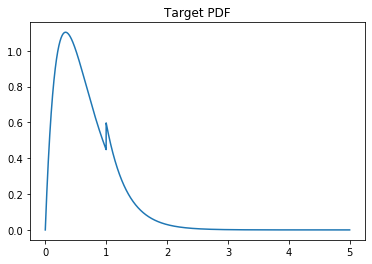

In [7]:
## What our target pdf looks like 
x = np.linspace(0,5,10000)
plt.plot(x, pdf_1b(x))
plt.title('Target PDF');

In [8]:
'''
Function sim_1b
A function that simulates the above pdf through Acceptance-Rejection

parameters:
    None
    
output:
    double, the simulated result
'''
def sim_1b():
    c = 4
    expn = sim_exp()
    if np.random.uniform() <= pdf_1b(expn)/(c*3*np.exp(-3*expn)):
        return expn
    else:
        return sim_1b()

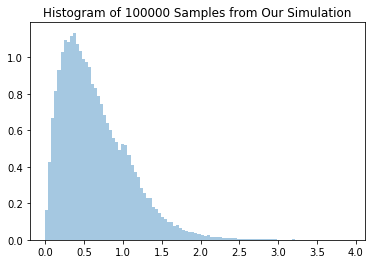

In [9]:
## Graphical illustration of our simulated distribution
try_1b = [sim_1b() for i in range(100000)]
sns.distplot(try_1b, bins = 100, kde = False, norm_hist = True)
plt.title('Histogram of 100000 Samples from Our Simulation');

In [10]:
## Something similar to part a) to find a confidence interval
## get N
pilot_size = 150
pilot_data = [sim_1b() for i in range(pilot_size)]
pilot_var = np.var(pilot_data)
z = st.norm.ppf(0.995)
target_N = int(np.ceil((z*np.sqrt(pilot_var)/0.01)**2))
## get CI
ob_sample = [sim_1b() for i in range(target_N)]
e_1b = np.mean(ob_sample)
se_1b = np.sqrt(np.var(ob_sample)/target_N)
CI_lower, CI_upper = e_1b - z * se_1b, e_1b + z * se_1b
## Output
print('The required sample size for the CI is: ' + str(target_N)) 
print('The estimated expect value of Xt is   : ' + str(np.round(e_1b, 4)))
print('The 99% confidence interval is        : ' + str((np.round((CI_lower, CI_upper), 4))))

The required sample size for the CI is: 9787
The estimated expect value of Xt is   : 0.6437
The 99% confidence interval is        : [0.6322 0.6552]


### c). Control Variate Simulation

In [11]:
'''
Function sim_1c
Vanilla simulation of the inter-arrival interval Xt = Wt+Vt.

parameters:
    n    : double, number of simulations 
    
output:
    xt: the n simulated intervals 
    wt: the n simulated wait times 
'''
def sim_1c(n = 1):
    xt = []
    wt = []
    while len(xt)<n:
        poisson_process = [0]
        while poisson_process[-1]<1:
            poisson_process.append(poisson_process[-1]+sim_exp())
        wti = poisson_process[-1] - 1
        vti = 1 - poisson_process[-2]
        xt.append(wti+vti)
        wt.append(wti)
    return xt, wt

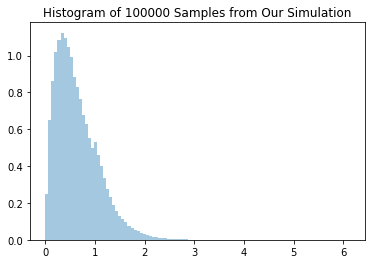

In [12]:
## Graphical illustration of our simulated distribution
sns.distplot(sim_1c(100000)[0], bins = 100, kde = False, norm_hist = True)
plt.title('Histogram of 100000 Samples from Our Simulation');

In [13]:
## Estimate the covariance and correlation between xt and wt through pilot study
pilot_data = sim_1c(100000)
cov_pilot = np.cov(pilot_data)[0,1]
corr_pilot = np.corrcoef(pilot_data)[0,1]

## variance of wt is 1/lambda(alpah, or 3) squared since wt is exponential
var_wt = 1/9
## get optimal c
c_star = cov_pilot/var_wt
## E(wt) is 1/3 by exponential
v = 1/3

## sample again for the actual controlled variable estimation
xt_control, wt_control = sim_1c(100000)
## get theta by formula
theta = np.mean(xt_control) + c_star*(v-np.mean(wt_control))

In [14]:
print('The estimated mean of Xt through control-variate is: ' + str(np.round(theta, 4)))
print('The variance of this estimation over the variance of vanilla Monte-Carlo is: ' 
      + str(np.round(1-corr_pilot**2, 4)))

The estimated mean of Xt through control-variate is: 0.6506
The variance of this estimation over the variance of vanilla Monte-Carlo is: 0.4053


## Q2

In [15]:
## Vanilla Monte Carlo as sanity check
n = 100000
test_2 = []
for k in range(n):
    test_2.append(np.sum([np.random.exponential(1)*(i+1) for i in range(5)]) >= 22)
print('Target estimated mean: ' + str(np.round(np.mean(test_2),4)))
print('Vanilla MC variance: ' + str(np.round(np.var(test_2),4)))

Target estimated mean: 0.1562
Vanilla MC variance: 0.1318


In [16]:
## Antithetic variable estimator
sims_2 = []
for k in range(n):
    unif2 = np.random.uniform(0,1,5)
    sims_2.append((int(np.sum([-np.log(unif2[i])*(i+1) for i in range(5)])>=22) + 
                int(np.sum([-np.log(1-unif2[i])*(i+1) for i in range(5)])>=22)) / 2)

print('The estimated Theta is :' + str(np.round(np.mean(sims_2),4)))
print('The variance of this antithetic estimator is: ' + str(np.round(np.var(sims_2),4)))
print('This variance is ' + str(np.round(np.var(sims_2)/np.var(test_2), 4)) + ' of the vanilla MC variance')

The estimated Theta is :0.1601
The variance of this antithetic estimator is: 0.0556
This variance is 0.4221 of the vanilla MC variance


In [17]:
## Theoretical improvement in variance
## Get the correlation through pilot study and plug into formula
n = 10000
sim_u = np.random.uniform(0,1,[5,n])
corr_anti = np.corrcoef([int(np.sum([-np.log(sim_u[i, k])*(i+1) for i in range(5)])>=22) for k in range(n)], 
                        [int(np.sum([-np.log(1-sim_u[i, k])*(i+1) for i in range(5)])>=22) for k in range(n)])[0,1]
print('Theoretically, the antithetic estimator\'s variance should be ' + str(np.round(1/2*(1+corr_anti),4)) 
      + ' of the vanilla MC variance, which is consistant with our result above')

Theoretically, the antithetic estimator's variance should be 0.4166 of the vanilla MC variance, which is consistant with our result above


## Q3

In [18]:
'''
Function sim_3_vanilla
Vanilla simulation of the claims

parameters:
    n    : double, number of simulations 
    
output:
    sim: the n simulated intervals 
    U: the n simulated uniform distributions  
'''
def sim_3_vanilla(n = 1):
    U = np.random.uniform(0, 1, n)
    sim = 1-st.poisson.cdf(19,15/(U+0.5))
    if n == 1:
        return sim[0], U[0]
    else: 
        return sim, U

In [19]:
## Vanilla Monte Carlo as sanity check
sim_vanilla = sim_3_vanilla(1000000)[0]
var_vanilla = np.var(sim_vanilla)
print('Target estimated mean: ' + str(np.round(np.mean(sim_vanilla), 4)))
print('Vanilla MC variance: ' + str(np.round(var_vanilla, 4)))

Target estimated mean: 0.2899
Vanilla MC variance: 0.1055


### a). Control variate estimation

In [20]:
## Control variable estimation
## Procedure similar to that of 1c)

## Find covariance and correlation through pilot study
sim_3_data, sim_3_U = sim_3_vanilla(100000)
cov_pilot = np.cov(sim_3_data, sim_3_U)[0,1]
corr_pilot = np.corrcoef(sim_3_data, sim_3_U)[0,1]

## uniform variance
var_unif = 1/12
## get optimal c
c_star = cov_pilot/var_unif
## uniform expectation
v = 1/2

## sample again for the actual controlled variable estimation
sim_3_control, u_3_control = sim_3_vanilla(100000)
## get p by formula
p_control = np.mean(sim_3_control) + c_star*(v-np.mean(u_3_control))
## variance of this estimation
var_control = np.var((sim_3_control) + c_star*(v-u_3_control))

print('The estimated probability by control variate is: ' + str(np.round(p_control,4)))
print('The variance of this estimation is: ' + str(np.round(var_control, 4)))
print('The variance of vanilla MC estimation is: ' + str(np.round(var_vanilla, 4)))
print('The theoretical variance of this estimation over the variance of vanilla Monte-Carlo is: ' 
      + str(np.round(1-corr_pilot**2, 4)))
print('From our simulation, the ratio is: ' + str(np.round(var_control/var_vanilla, 4)))

The estimated probability by control variate is: 0.29
The variance of this estimation is: 0.0163
The variance of vanilla MC estimation is: 0.1055
The theoretical variance of this estimation over the variance of vanilla Monte-Carlo is: 0.1544
From our simulation, the ratio is: 0.1542


### b). Antithetic estimation

In [21]:
## Simulate uniforms first
U = np.random.uniform(0, 1, 1000000)
## Then simulate the corresponding Poissons
sim1 = 1 - st.poisson.cdf(k = 19, mu = 15/(U+0.5))
sim2 = 1 - st.poisson.cdf(k = 19, mu = 15/(1-U+0.5))
## This sample can also be used as the pilot study for the correlation. It won't affect the result
corr_anti = np.corrcoef(sim1, sim2)[0,1]
## antithetic sampe
sim_3_anti = (sim1+sim2)/2
## get estimated probability
p_anti = np.mean(sim_3_anti)
## variance of the estimation
var_anti = np.var(sim_3_anti)

print('The estimated probability by antithetic sampling is: ' + str(np.round(p_anti,4)))
print('The variance of this estimation is: ' + str(np.round(var_anti, 4)))
print('The variance of vanilla MC estimation is: ' + str(np.round(var_vanilla, 4)))
print('The theoretical variance of this estimation over the variance of vanilla Monte-Carlo is: ' 
      + str(np.round((1+corr_anti)/2, 4)))
print('From our simulation, the ratio is: ' + str(np.round(var_anti/var_vanilla, 4)))

The estimated probability by antithetic sampling is: 0.2897
The variance of this estimation is: 0.0161
The variance of vanilla MC estimation is: 0.1055
The theoretical variance of this estimation over the variance of vanilla Monte-Carlo is: 0.1525
From our simulation, the ratio is: 0.1525
